In [19]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import missingno as msno
pd.set_option('display.max_columns', None)  # Display all columns

In [20]:
df = pd.read_csv('Electric_Vehicle_Population_Data.csv')

In [21]:
#display first 2 rows of the dataset
display(df.head(2))

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EB4L,Yakima,Yakima,WA,98908.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,14.0,127175366,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10
1,5YJ3E1EA7K,San Diego,San Diego,CA,92101.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,NaN,266614659,POINT (-117.16171 32.71568),NaN,6.073005e+09


## DATA PROCESSING
Handling missing values by dropping rows

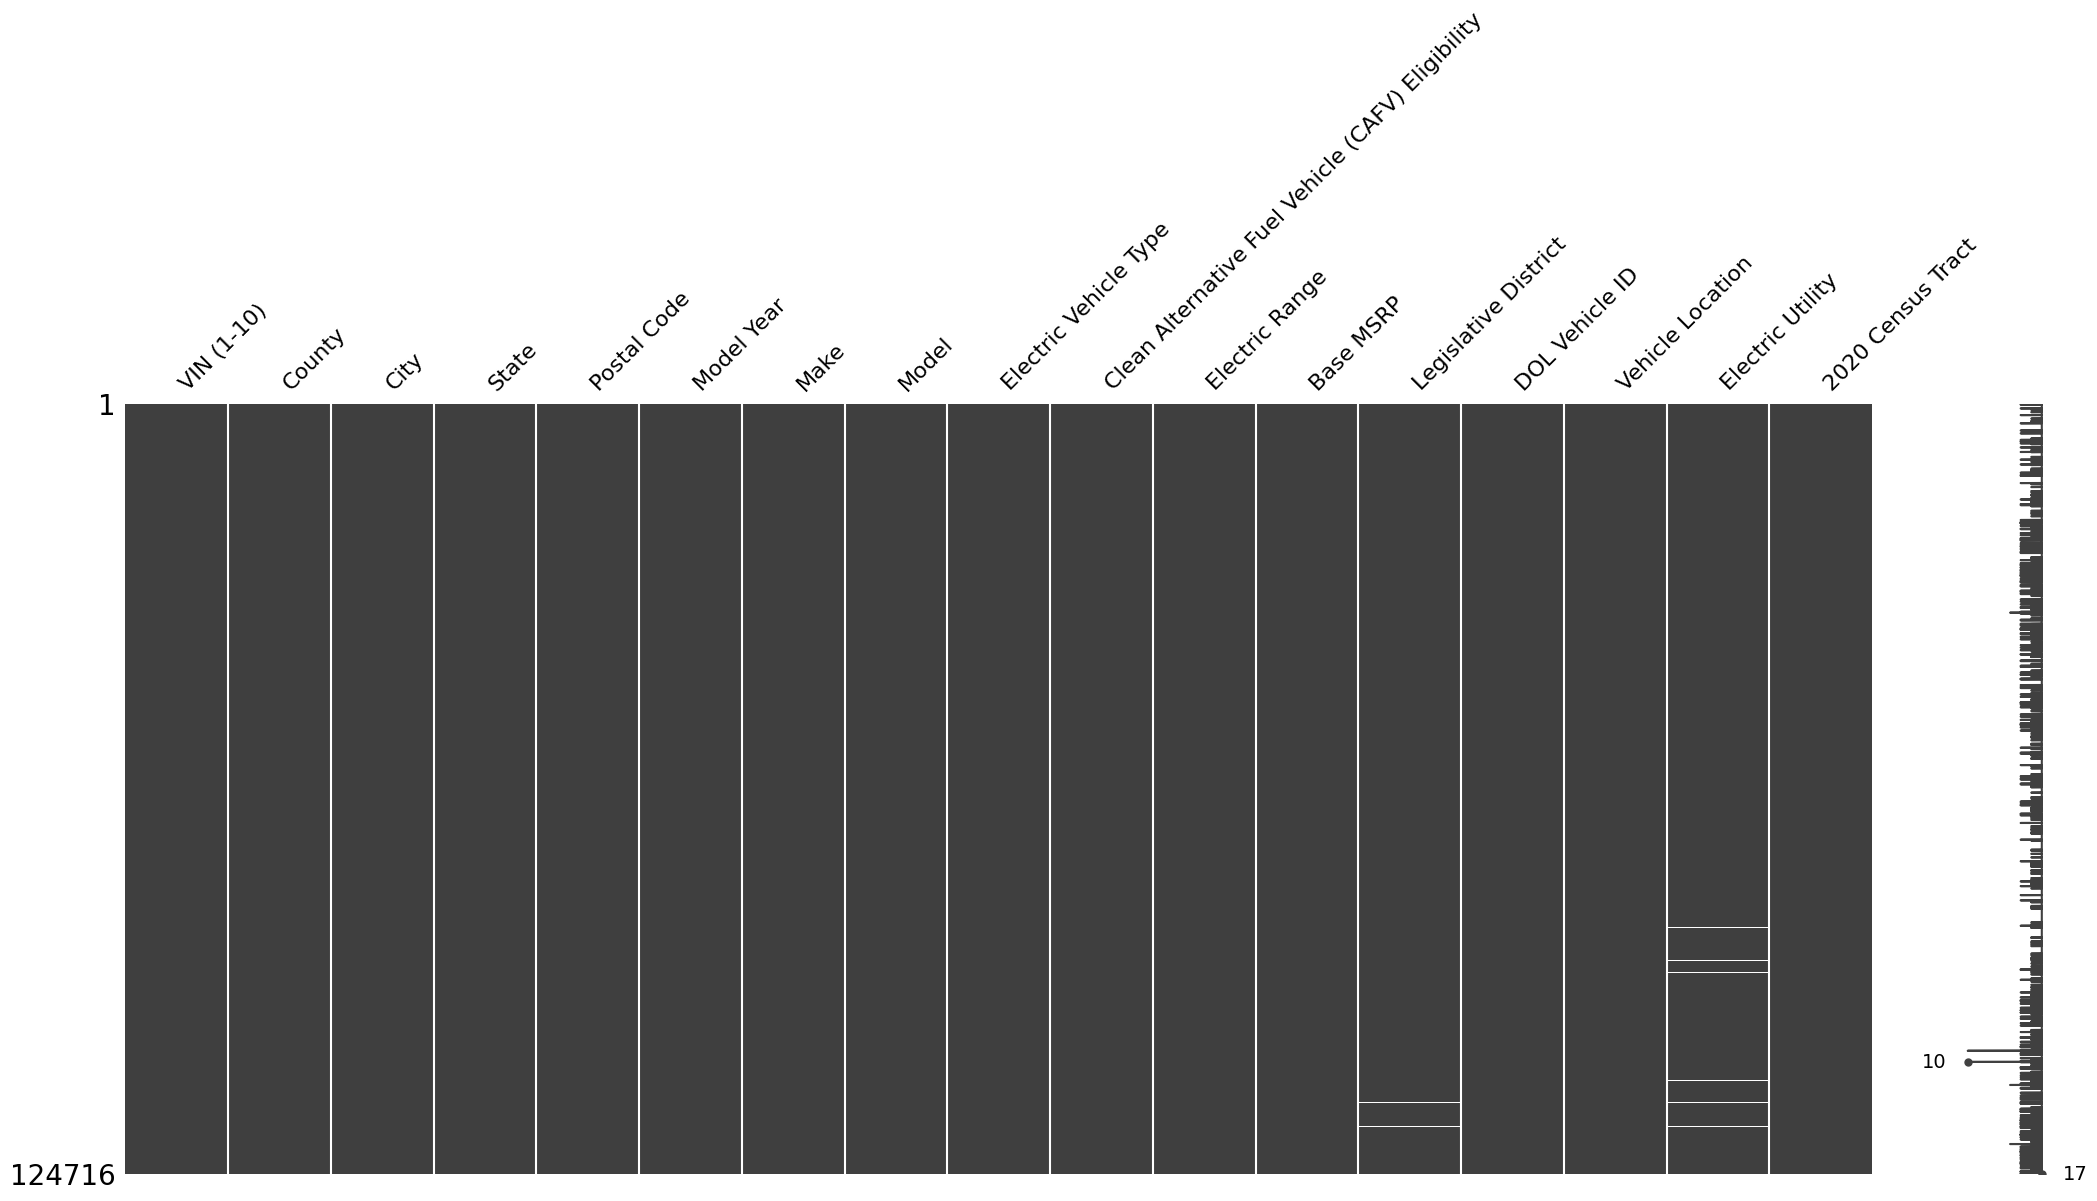

In [22]:
# Visualize missing values using missingno
msno.matrix(df);

In [23]:
# Dropping the missing values
df = df.dropna()

# DATA ENGINEERING
In the dataset we can see that the column Vehicle Location contains latitude and longitude data as a string. In order to perform better analysis we will create a column for latitude and one for the longitude

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124038 entries, 0 to 124715
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         124038 non-null  object 
 1   County                                             124038 non-null  object 
 2   City                                               124038 non-null  object 
 3   State                                              124038 non-null  object 
 4   Postal Code                                        124038 non-null  float64
 5   Model Year                                         124038 non-null  int64  
 6   Make                                               124038 non-null  object 
 7   Model                                              124038 non-null  object 
 8   Electric Vehicle Type                              124038 non-null  object

In [25]:
def get_coordinate (x, index):
  cords = re.findall(r'-?\d+\.\d+', x)
  if len(cords)>=2:
    return float(cords[index])
  else:
    return None

df['latitude'] = df['Vehicle Location'].apply(lambda x: get_coordinate(x, 0))
df['longitude'] = df['Vehicle Location'].apply(lambda x: get_coordinate(x, 1))

df =df.dropna(subset=['latitude', 'longitude'])

In [26]:
df['latitude'], df['longitude']

(0        -120.56916
 3        -120.56916
 4        -122.18384
 5        -122.20596
 6        -122.64681
             ...    
 124711   -121.98087
 124712   -122.52054
 124713   -122.49756
 124714   -122.46495
 124715   -119.48756
 Name: latitude, Length: 124038, dtype: float64,
 0         46.58514
 3         46.58514
 4         47.80310
 5         47.97659
 6         47.73689
             ...   
 124711    47.85260
 124712    47.26887
 124713    48.79990
 124714    47.16778
 124715    46.26543
 Name: longitude, Length: 124038, dtype: float64)

## Creating a Location Column
We will create a location column as the concatenation of County, City and State

In [27]:
df['location'] = df['County'] + ', ' + ['City'] + ', ' + ['State']
df['location']

0            Yakima, City, State
3            Yakima, City, State
4         Snohomish, City, State
5         Snohomish, City, State
6            Kitsap, City, State
                   ...          
124711    Snohomish, City, State
124712       Pierce, City, State
124713      Whatcom, City, State
124714       Pierce, City, State
124715       Benton, City, State
Name: location, Length: 124038, dtype: object

## Creating a Price Range Category Column
We will create a price range category column
if Base MSRP is 0 then Unknown
if Base MSRP is less than 40k is low
if Base MSRP is between 40k and 60k is medium
if Base MSRPis more than 60k is high

In [28]:
df['Base MSRP'].value_counts()

0         120656
69900       1429
31950        402
52900        167
32250        155
54950        138
59900        127
39995        119
36900         98
44100         97
64950         87
33950         80
45600         74
34995         63
52650         61
36800         51
55700         48
53400         35
110950        21
98950         21
81100         19
75095         16
90700         16
102000        14
184400        12
43700         11
109000         7
89100          6
91250          4
32995          3
845000         1
Name: Base MSRP, dtype: int64

In [29]:
def categorize_price(price):
  if price == 0:
      return "Unknown"
  elif price < 40000:
      return "Low"
  elif price < 60000:
      return "Medium"
  else:
      return "High"

df['Price_Range_Category'] = df['Base MSRP'].apply(categorize_price)
df['Price_Range_Category'].value_counts().unique(), df['Price_Range_Category'].unique()

(array([120656,   1653,    971,    758]),
 array(['Unknown', 'Low', 'Medium', 'High'], dtype=object))

## Creating an Electric Range Cateogry
We will create a electric range category column
if Electric Range is 0 then Unknown
if Electric Range is less than 150 is short
if Electric Range is between 300 is medium
if Electric Range more than 300 is long

In [30]:
def categorize_electric(electric_range):
  if electric_range == 0:
      return "Unknown"
  elif electric_range < 150:
      return "Short"
  elif electric_range < 300:
      return "Medium"
  else:
      return "High"

df['Electric_Range_Category'] = df['Electric Range'].apply(categorize_electric)
df['Electric_Range_Category'].value_counts().unique(), df['Electric_Range_Category'].unique()

(array([49346, 40611, 31562,  2519]),
 array(['High', 'Medium', 'Short', 'Unknown'], dtype=object))